In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
# Unzip data file
!unzip garbage.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

In [3]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('garbage_classification')

# Split the dataset
total_size = len(dataset)
train_size = int(0.8 * total_size)
validation_size = total_size - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Apply the appropriate transforms to the subsets
train_dataset.dataset.transform = train_transforms
validation_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

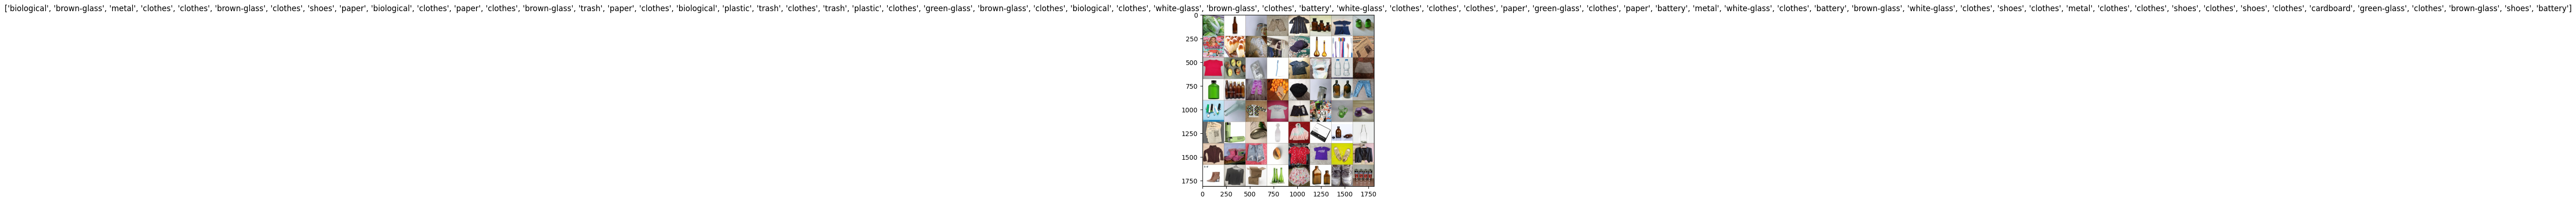

In [4]:
# Visualize images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = dataset.classes
imshow(out, title=[class_names[x] for x in classes])

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Load MobileNetV3 large model
model = models.quantization.mobilenet_v3_large(pretrained=True, quantized=True)

# Freeze all the pretrained weights for transfer learning
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 49.0MB/s]


QuantizableMobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): QuantizableInvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (2): QuantizableInvertedResidual(
      (block): Sequ

In [6]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [7]:
epochs = 7
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    # Print epoch stats
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss/len(val_loader.dataset):.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

Epoch 1/7
Train Loss: 0.5704, Train Accuracy: 85.51%
Validation Loss: 0.2579, Validation Accuracy: 92.65%

Epoch 2/7
Train Loss: 0.2518, Train Accuracy: 92.84%
Validation Loss: 0.2179, Validation Accuracy: 93.39%

Epoch 3/7
Train Loss: 0.2008, Train Accuracy: 94.38%
Validation Loss: 0.2022, Validation Accuracy: 93.84%

Epoch 4/7
Train Loss: 0.1723, Train Accuracy: 94.89%
Validation Loss: 0.1905, Validation Accuracy: 94.42%

Epoch 5/7
Train Loss: 0.1535, Train Accuracy: 95.59%
Validation Loss: 0.1811, Validation Accuracy: 94.39%

Epoch 6/7
Train Loss: 0.1359, Train Accuracy: 95.83%
Validation Loss: 0.1812, Validation Accuracy: 94.30%

Epoch 7/7
Train Loss: 0.1259, Train Accuracy: 96.33%
Validation Loss: 0.1770, Validation Accuracy: 94.17%



In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

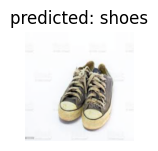

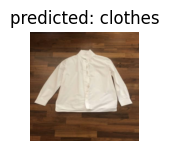

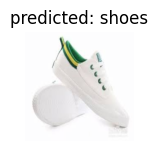

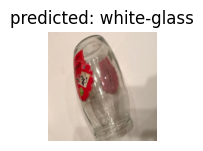

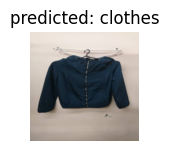

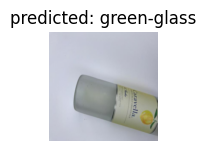

In [9]:
visualize_model(model)

In [10]:
torch.save(model.state_dict(), 'quantized_mobilenet_v3_large.pth')
#torch.save(model, 'quantized_mobilenet_v3_large.pth')